<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/thermodynamics/c1_co2_h2s_flash_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install NeqSim python package
For learning of how to use NeqSim see the [NeqSim github page](https://equinor.github.io/neqsimhome/).

See [TPflash algorithm documentation](https://github.com/equinor/neqsim/blob/master/docs/thermodynamicoperations/TPflash_algorithm.md).

See paper [Professor Michelsen’s impact on physical property prediction at Linde engineering and ideas for future directions](https://www.sciencedirect.com/science/article/abs/pii/S0378381223002996).

In [ ]:
!pip install neqsim -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 15.1 MB/s eta 0:00:00


# Phase diagram for C1-CO2-H2S for a specified binary interaction parameter
This phase diagram illustrates the different phase regions of the system. The colored areas indicate the number of phases or specific phase combinations. Superimposed contour lines represent the mole fraction of the lightest phase across pressure–temperature conditions, providing additional insight into how the phase composition evolves throughout the diagram.

The distinction between gas and liquid phases is inherently arbitrary in this context. The transition in density from gas-like to liquid-like behavior is continuous, with no sharp discontinuity. Consequently, the gas–liquid transition does not correspond to a true thermodynamic phase boundary, but rather reflects a gradual and continuous change in physical properties. In NeqSim, the liquid phase is defined using the criterion \( v/b < 1.75 \).

time per flash  5.90401881535848  msec


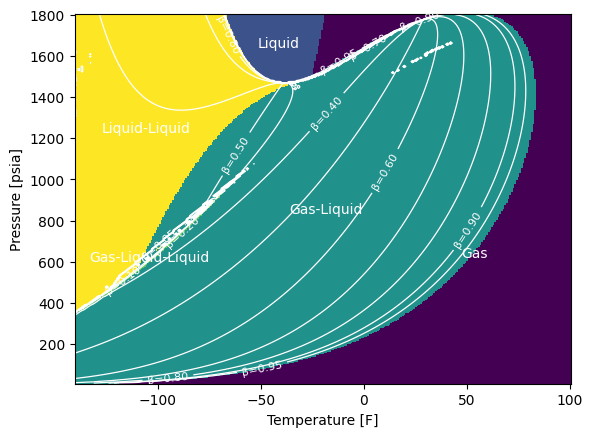

In [ ]:
from neqsim import jneqsim
from neqsim.thermo import TPflash
import time
import numpy as np

x_y_points = 300

# Define pressure and temperature ranges
min_pressure_val = 10.0 # psia
max_pressure_val = 1800.0 # psia
min_temperature_val = -140.0 # F
max_temperature_val = 100.0 # F

pressure_step = (max_pressure_val - min_pressure_val) / (x_y_points - 1)
temperature_step = (max_temperature_val - min_temperature_val) / (x_y_points - 1)

testSystem = jneqsim.thermo.system.SystemPrEos(); # other models can be selected from: https://github.com/equinor/neqsim/tree/master/src/main/java/neqsim/thermo/system
testSystem.addComponent("methane", 49.88);
testSystem.addComponent("CO2", 9.87);
testSystem.addComponent("H2S", 40.22);

testSystem.setMixingRule("classic");

testSystem.setEnhancedMultiPhaseCheck(True);

# set kij
#testSystem.setBinaryInteractionParameter(0, 1, 0.09) #C1-CO2
#testSystem.setBinaryInteractionParameter(0, 2, 0.09) #C1-H2S
#testSystem.setBinaryInteractionParameter(1, 2, 0.04) #CO2-H2S

data = np.zeros([x_y_points, x_y_points], dtype=np.uint8)
density_data = np.zeros([x_y_points, x_y_points])
lightest_phase_data = np.zeros([x_y_points, x_y_points])
pressures = []
temperatures = []

start = time.time()

for i in range(data.shape[0]):
  pres = min_pressure_val + i * pressure_step # Calculate pressure based on defined range
  testSystem.setPressure(pres, "psia")
  pressures.append(pres)
  if i == 0:
    for j in range(data.shape[1]):
        temp = min_temperature_val + j * temperature_step # Calculate temperature based on defined range
        temperatures.append(temp)

  for j in range(data.shape[1]):
    testSystem.setTemperature(temperatures[j], "F")

    try:
      TPflash(testSystem)
      data[i][j] = testSystem.getNumberOfPhases()
      testSystem.initPhysicalProperties('density')
      density_data[i][j] = testSystem.getDensity('kg/m3')
      lightest_phase_data[i][j] = testSystem.getBeta()

      if(testSystem.getNumberOfPhases()==1 and testSystem.hasPhaseType('gas')):
        data[i][j] = 4
      elif(testSystem.getNumberOfPhases()==1 and (testSystem.hasPhaseType('oil'))):
        data[i][j] = 5
      elif(testSystem.getNumberOfPhases()==2 and testSystem.hasPhaseType('gas')):
        data[i][j] = 6
      elif(testSystem.getNumberOfPhases()==3):
        data[i][j] = 7
      elif(testSystem.getNumberOfPhases()==2 and not testSystem.hasPhaseType('gas')):
        data[i][j] = 8
      else:
        print('should not go here')
    except:
       print('except')
       data[i][j] = 12

end  = time.time()
time = end-start

print('time per flash ', time/(x_y_points*x_y_points)*1000, ' msec')


import matplotlib.pyplot as plt
import numpy as np

# Assuming the data array and other variables are already populated

# Define a dictionary to map data values to region names
region_labels = {
    4: 'Gas',
    5: 'Liquid',
    6: 'Gas-Liquid',
    7: 'Gas-Liquid-Liquid',
    8: 'Liquid-Liquid'
    }

# Dictionary to store the coordinates of all points in each region
region_points = {key: [] for key in region_labels.keys()}

# Collect all points for each region
for i in range(x_y_points):
    for j in range(x_y_points):
        region_value = data[i][j]
        if region_value in region_points:
            region_points[region_value].append((temperatures[j], pressures[i]))

# Plot the data
plt.pcolormesh(temperatures, pressures, data, cmap='viridis')
plt.xlabel('Temperature [F]')
plt.ylabel('Pressure [psia]')

# Add one label at the center of each region
for region_value, points in region_points.items():
    if points:
        # Calculate the centroid of the region
        avg_temp = np.mean([p[0] for p in points])
        avg_pres = np.mean([p[1] for p in points])
        # Place the label at the centroid
        plt.text(avg_temp, avg_pres, region_labels[region_value], fontsize=10, ha='center', va='center', color='white')

# ----------------------------------------
# Mask beta where single-phase
# ----------------------------------------
beta_masked = np.ma.masked_invalid(lightest_phase_data)

# ----------------------------------------
# Beta contour lines
# ----------------------------------------
beta_levels = [0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

CS = plt.contour(
    temperatures,
    pressures,
    beta_masked,
    levels=beta_levels,
    colors='white',
    linewidths=0.9
)

plt.clabel(
    CS,
    inline=True,
    fontsize=8,
    fmt=lambda x: f"β={x:.2f}"
)

plt.show()

## Discussion

The three critical points discussed in the paper *“Professor Michelsen’s impact on physical property prediction at Linde Engineering and ideas for future directions”* can be observed (or at least appear consistent with the results shown here).

At low temperatures and high pressures, whether the methane-rich phase is referred to as a gas or a liquid is largely a matter of definition. As illustrated below, the transition in density from gas-like to liquid-like behavior (indicated by the color change from green to yellow) is continuous. There is no sharp discontinuity in density, and the gas–liquid transition does not represent a true phase boundary, but rather a gradual change in physical properties. In NeqSim, the liquid phase is defined using the criterion \( v/b < 1.75 \).

Additionally, a narrow region with three coexisting phases can be observed at low temperatures.


Effect of kij was not looked into here. Default kij in neqsim was used. Binary inteaction parameters can bee obtained by command: testSystem.getPhase(0).getEosMixingRule().getBinaryInteractionParameter(0, 1) for methane-CO2.

In [ ]:
from neqsim import jneqsim
jneqsim.util.unit.Units.activateFieldUnits();

In [ ]:
from neqsim.thermo import printFrame, TPflash
testSystem.setTemperature(-70, "F")
testSystem.setPressure(1000, "psia")
TPflash(testSystem)
printFrame(testSystem)

| 0                    | 1           | 2                  | 3                  | 4   | 5   | 6               |
|:---------------------|:------------|:-------------------|:-------------------|:----|:----|:----------------|
|                      | total       | GAS                | OIL                |     |     |                 |
| methane              | 4.9895E-1   | 7.07236E-1         | 2.89086E-1         |     |     | [mole fraction] |
| CO2                  | 9.87296E-2  | 9.31809E-2         | 1.0432E-1          |     |     | [mole fraction] |
| H2S                  | 4.02321E-1  | 1.99583E-1         | 6.06593E-1         |     |     | [mole fraction] |
|                      |             |                    |                    |     |     |                 |
| Density              |             | 2.41811E1          | 4.57499E1          |     |     | lb/ft3          |
| Phase Fraction       |             | 5.01886E-1         | 4.98114E-1         |     |     | [mole fraction] |
|

In [ ]:
from neqsim.thermo import printFrame, TPflash
testSystem.setTemperature(-87, "F")
testSystem.setPressure(1000, "psia")
TPflash(testSystem)
printFrame(testSystem)

| 0                    | 1           | 2                  | 3                  | 4   | 5   | 6               |
|:---------------------|:------------|:-------------------|:-------------------|:----|:----|:----------------|
|                      | total       | OIL                | OIL                |     |     |                 |
| methane              | 4.9895E-1   | 6.92725E-1         | 2.52716E-1         |     |     | [mole fraction] |
| CO2                  | 9.87296E-2  | 9.72334E-2         | 1.00631E-1         |     |     | [mole fraction] |
| H2S                  | 4.02321E-1  | 2.10042E-1         | 6.46653E-1         |     |     | [mole fraction] |
|                      |             |                    |                    |     |     |                 |
| Density              |             | 2.73783E1          | 4.85544E1          |     |     | lb/ft3          |
| Phase Fraction       |             | 5.59611E-1         | 4.40389E-1         |     |     | [mole fraction] |
|

#Calculations close critical points
We will carry out calculations in the vicinity of the critical point to investigate how the properties of the phases approach one another in this region.

## Critical point 1

In [ ]:
from neqsim.thermo import printFrame, TPflash
testSystem.setTemperature(20, "F")
testSystem.setPressure(1740, "psia")
TPflash(testSystem)
printFrame(testSystem)

| 0                    | 1           | 2                  | 3                  | 4   | 5   | 6               |
|:---------------------|:------------|:-------------------|:-------------------|:----|:----|:----------------|
|                      | total       | GAS                | OIL                |     |     |                 |
| methane              | 4.9895E-1   | 5.3505E-1          | 4.87897E-1         |     |     | [mole fraction] |
| CO2                  | 9.87296E-2  | 9.77925E-2         | 9.90165E-2         |     |     | [mole fraction] |
| H2S                  | 4.02321E-1  | 3.67157E-1         | 4.13087E-1         |     |     | [mole fraction] |
|                      |             |                    |                    |     |     |                 |
| Density              |             | 2.40749E1          | 2.70782E1          |     |     | lb/ft3          |
| Phase Fraction       |             | 2.34401E-1         | 7.65599E-1         |     |     | [mole fraction] |
|

## Critical point 2

In [ ]:
from neqsim.thermo import printFrame, TPflash
testSystem.setTemperature(-40, "F")
testSystem.setPressure(1470, "psia")
TPflash(testSystem)
printFrame(testSystem)

| 0                    | 1           | 2           | 3           | 4   | 5   | 6               |
|:---------------------|:------------|:------------|:------------|:----|:----|:----------------|
|                      | total       | OIL         | OIL         |     |     |                 |
| methane              | 4.9895E-1   | 5.02718E-1  | 4.87156E-1  |     |     | [mole fraction] |
| CO2                  | 9.87296E-2  | 9.86704E-2  | 9.89149E-2  |     |     | [mole fraction] |
| H2S                  | 4.02321E-1  | 3.98611E-1  | 4.13929E-1  |     |     | [mole fraction] |
|                      |             |             |             |     |     |                 |
| Density              |             | 3.3091E1    | 3.3906E1    |     |     | lb/ft3          |
| Phase Fraction       |             | 7.57832E-1  | 2.42168E-1  |     |     | [mole fraction] |
| Molar Mass           | 2.60608E1   | 2.59923E1   | 2.62754E1   |     |     | lbm/lbmol       |
| Z factor             |      

## Critical point 3

Difficult to see last critical point (so lets do a more detailed analysis around the temperature and pressure region).

time per flash  8.074622112512587  msec


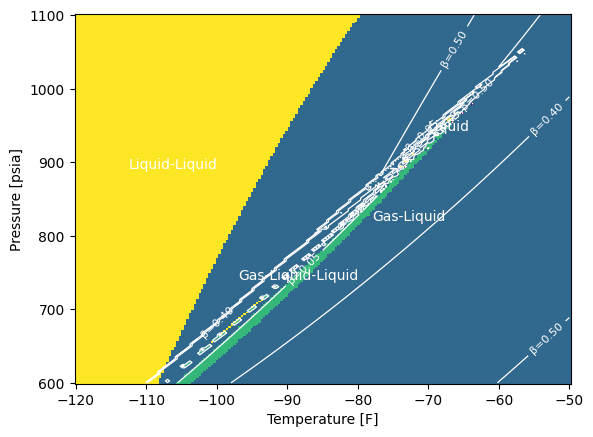

In [ ]:
from neqsim import jneqsim
from neqsim.thermo import TPflash
import time
import numpy as np

x_y_points = 200

# Define pressure and temperature ranges
min_pressure_val = 600.0 # psia
max_pressure_val = 1100.0 # psia
min_temperature_val = -120.0 # F
max_temperature_val = -50.0 # F

pressure_step = (max_pressure_val - min_pressure_val) / (x_y_points - 1)
temperature_step = (max_temperature_val - min_temperature_val) / (x_y_points - 1)

testSystem = jneqsim.thermo.system.SystemPrEos(); # other models can be selected from: https://github.com/equinor/neqsim/tree/master/src/main/java/neqsim/thermo/system
testSystem.addComponent("methane", 49.88);
testSystem.addComponent("CO2", 9.87);
testSystem.addComponent("H2S", 40.22);

testSystem.setMixingRule("classic");

testSystem.setEnhancedMultiPhaseCheck(True);

# set kij
#testSystem.setBinaryInteractionParameter(0, 1, 0.09) #C1-CO2
#testSystem.setBinaryInteractionParameter(0, 2, 0.09) #C1-H2S
#testSystem.setBinaryInteractionParameter(1, 2, 0.04) #CO2-H2S

data = np.zeros([x_y_points, x_y_points], dtype=np.uint8)
density_data = np.zeros([x_y_points, x_y_points])
lightest_phase_data = np.zeros([x_y_points, x_y_points])
pressures = []
temperatures = []

start = time.time()

for i in range(data.shape[0]):
  pres = min_pressure_val + i * pressure_step # Calculate pressure based on defined range
  testSystem.setPressure(pres, "psia")
  pressures.append(pres)
  if i == 0:
    for j in range(data.shape[1]):
        temp = min_temperature_val + j * temperature_step # Calculate temperature based on defined range
        temperatures.append(temp)

  for j in range(data.shape[1]):
    testSystem.setTemperature(temperatures[j], "F")

    try:
      TPflash(testSystem)
      data[i][j] = testSystem.getNumberOfPhases()
      testSystem.initPhysicalProperties('density')
      density_data[i][j] = testSystem.getDensity('kg/m3')
      lightest_phase_data[i][j] = testSystem.getBeta()

      if(testSystem.getNumberOfPhases()==1 and testSystem.hasPhaseType('gas')):
        data[i][j] = 4
      elif(testSystem.getNumberOfPhases()==1 and (testSystem.hasPhaseType('oil'))):
        data[i][j] = 5
      elif(testSystem.getNumberOfPhases()==2 and testSystem.hasPhaseType('gas')):
        data[i][j] = 6
      elif(testSystem.getNumberOfPhases()==3):
        data[i][j] = 7
      elif(testSystem.getNumberOfPhases()==2 and not testSystem.hasPhaseType('gas')):
        data[i][j] = 8
      else:
        print('should not go here')
    except:
       print('except')
       data[i][j] = 12

end  = time.time()
time = end-start

print('time per flash ', time/(x_y_points*x_y_points)*1000, ' msec')


import matplotlib.pyplot as plt
import numpy as np

# Assuming the data array and other variables are already populated

# Define a dictionary to map data values to region names
region_labels = {
    4: 'Gas',
    5: 'Liquid',
    6: 'Gas-Liquid',
    7: 'Gas-Liquid-Liquid',
    8: 'Liquid-Liquid'
    }

# Dictionary to store the coordinates of all points in each region
region_points = {key: [] for key in region_labels.keys()}

# Collect all points for each region
for i in range(x_y_points):
    for j in range(x_y_points):
        region_value = data[i][j]
        if region_value in region_points:
            region_points[region_value].append((temperatures[j], pressures[i]))

# Plot the data
plt.pcolormesh(temperatures, pressures, data, cmap='viridis')
plt.xlabel('Temperature [F]')
plt.ylabel('Pressure [psia]')

# Add one label at the center of each region
for region_value, points in region_points.items():
    if points:
        # Calculate the centroid of the region
        avg_temp = np.mean([p[0] for p in points])
        avg_pres = np.mean([p[1] for p in points])
        # Place the label at the centroid
        plt.text(avg_temp, avg_pres, region_labels[region_value], fontsize=10, ha='center', va='center', color='white')

# ----------------------------------------
# Mask beta where single-phase
# ----------------------------------------
beta_masked = np.ma.masked_invalid(lightest_phase_data)

# ----------------------------------------
# Beta contour lines
# ----------------------------------------
beta_levels = [0.05, 0.4, 0.5, 0.95]

CS = plt.contour(
    temperatures,
    pressures,
    beta_masked,
    levels=beta_levels,
    colors='white',
    linewidths=0.9
)

plt.clabel(
    CS,
    inline=True,
    fontsize=8,
    fmt=lambda x: f"β={x:.2f}"
)

plt.show()

In [ ]:
from neqsim.thermo import TPflash, printFrame
import numpy as np

# --- Search window around initial guess ---
T_center_F = -65.0
P_center_psia = 900.0

T_range_F = np.linspace(T_center_F - 20, T_center_F + 20, 100)
P_range_psia = np.linspace(P_center_psia - 100, P_center_psia + 300, 100)

best_point = None
max_pressure = -1.0

for T in T_range_F:
    for P in P_range_psia:
        try:
            testSystem.setTemperature(T, "F")
            testSystem.setPressure(P, "psia")

            TPflash(testSystem)

            nph = testSystem.getNumberOfPhases()

            if nph == 3 and P > max_pressure:
                max_pressure = P
                best_point = (T, P)

        except Exception:
            # TPflash may fail near critical or unstable regions
            pass

if best_point is not None:
    T_best, P_best = best_point

    print("\n=== HIGHEST-PRESSURE THREE-PHASE POINT FOUND ===")
    print(f"Temperature: {T_best:.2f} °F")
    print(f"Pressure:    {P_best:.2f} psia\n")

    testSystem.setTemperature(T_best, "F")
    testSystem.setPressure(P_best, "psia")
    TPflash(testSystem)

    printFrame(testSystem)
else:
    print("No three-phase point found in the scanned region.")



=== HIGHEST-PRESSURE THREE-PHASE POINT FOUND ===
Temperature: -65.81 °F
Pressure:    966.67 psia

| 0                    | 1           | 2                 | 3                 | 4                 | 5   | 6               |
|:---------------------|:------------|:------------------|:------------------|:------------------|:----|:----------------|
|                      | total       | GAS               | OIL               | OIL               |     |                 |
| methane              | 4.9895E-1   | 8.48645E-1        | 7.49407E-1        | 2.99042E-1        |     | [mole fraction] |
| CO2                  | 9.87296E-2  | 6.36833E-2        | 8.86399E-2        | 1.11274E-1        |     | [mole fraction] |
| H2S                  | 4.02321E-1  | 8.76717E-2        | 1.61953E-1        | 5.89684E-1        |     | [mole fraction] |
|                      |             |                   |                   |                   |     |                 |
| Density              |             | 1

Search for critical point (where phase properties are the same).

In [ ]:
from neqsim.thermo import TPflash, printFrame
import numpy as np

# ------------------------------------------------
# Search window
# ------------------------------------------------
T_center_F = -66.5
P_center_psia = 961.0

T_range_F = np.linspace(T_center_F - 5, T_center_F + 5, 100)
P_range_psia = np.linspace(P_center_psia - 20, P_center_psia + 20, 100)

# ------------------------------------------------
# Scaling factors (order-of-magnitude)
# ------------------------------------------------
x_scale = 0.1        # composition distance
rho_scale = 10.0    # lb/ft3

best_candidate = None
best_score = 1e9

# ------------------------------------------------
# Scan
# ------------------------------------------------
for T in T_range_F:
    for P in P_range_psia:
        try:
            testSystem.setTemperature(T, "F")
            testSystem.setPressure(P, "psia")

            TPflash(testSystem)

            nph = testSystem.getNumberOfPhases()
            if nph < 2:
                continue

            # Collect phase data
            phases = []
            for i in range(nph):
                phase = testSystem.getPhase(i)
                x = np.array([
                    phase.getComponent(k).getx()
                    for k in range(phase.getNumberOfComponents())
                ])
                rho = phase.getDensity("lb/ft3")
                phases.append((x, rho))

            # Compare all phase pairs
            for i in range(nph):
                for j in range(i + 1, nph):
                    dx = np.linalg.norm(phases[i][0] - phases[j][0])
                    drho = abs(phases[i][1] - phases[j][1])

                    criticality = dx / x_scale + drho / rho_scale

                    # Keep best (most critical-like) point
                    if criticality < best_score:
                        best_score = criticality
                        best_candidate = {
                            "T": T,
                            "P": P,
                            "dx": dx,
                            "drho": drho,
                            "pair": (i, j),
                            "nph": nph
                        }

        except Exception:
            pass

# ------------------------------------------------
# Report result
# ------------------------------------------------
if best_candidate is not None:
    print("\n=== MOST CRITICAL-LIKE POINT FOUND ===")
    print(f"Temperature: {best_candidate['T']:.2f} °F")
    print(f"Pressure:    {best_candidate['P']:.2f} psia")
    print(f"Phases:      {best_candidate['nph']}")
    print(f"Phase pair:  {best_candidate['pair']}")
    print(f"Δx:          {best_candidate['dx']:.4e}")
    print(f"Δρ:          {best_candidate['drho']:.4e} lb/ft3")
    print(f"Score:       {best_score:.4e}\n")

    testSystem.setTemperature(best_candidate["T"], "F")
    testSystem.setPressure(best_candidate["P"], "psia")
    TPflash(testSystem)

    printFrame(testSystem)

else:
    print("No critical-like point found in the scanned region.")



=== MOST CRITICAL-LIKE POINT FOUND ===
Temperature: -65.44 °F
Pressure:    971.71 psia
Phases:      3
Phase pair:  (0, 1)
Δx:          1.1629e-01
Δρ:          7.9534e+00 lb/ft3
Score:       1.9583e+00

| 0                    | 1          | 2                  | 3                  | 4                  | 5   | 6               |
|:---------------------|:-----------|:-------------------|:-------------------|:-------------------|:----|:----------------|
|                      | total      | GAS                | OIL                | OIL                |     |                 |
| methane              | 4.9895E-1  | 8.45831E-1         | 7.54601E-1         | 2.98147E-1         |     | [mole fraction] |
| CO2                  | 9.87296E-2 | 6.41341E-2         | 8.69481E-2         | 1.10173E-1         |     | [mole fraction] |
| H2S                  | 4.02321E-1 | 9.00352E-2         | 1.58451E-1         | 5.9168E-1          |     | [mole fraction] |
|                      |            |          

The denisties and properties approach each other, but don't know if it is a true critical point. A three-phase equilibrium terminates because two phases become critical. This is called a critical end point.